In [1]:
import matplotlib.pyplot as plt
plt.close()

### EMM / State version

C:\Users\Handi\AppData\Local\Temp\ipykernel_38124\1260306310.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey=True)


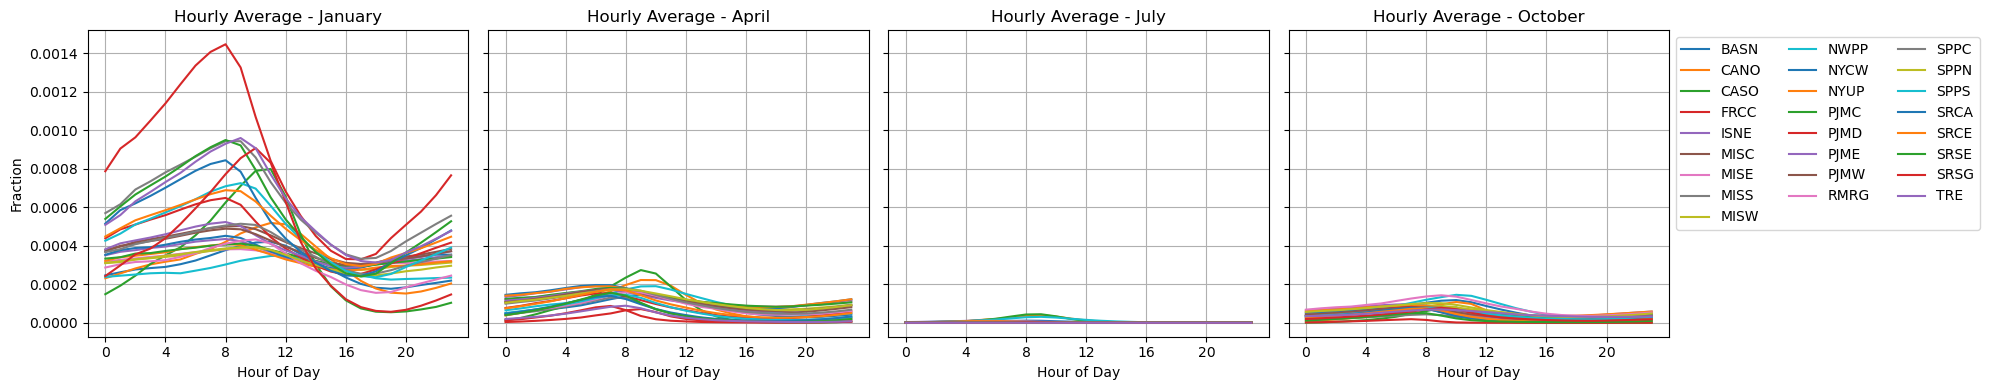

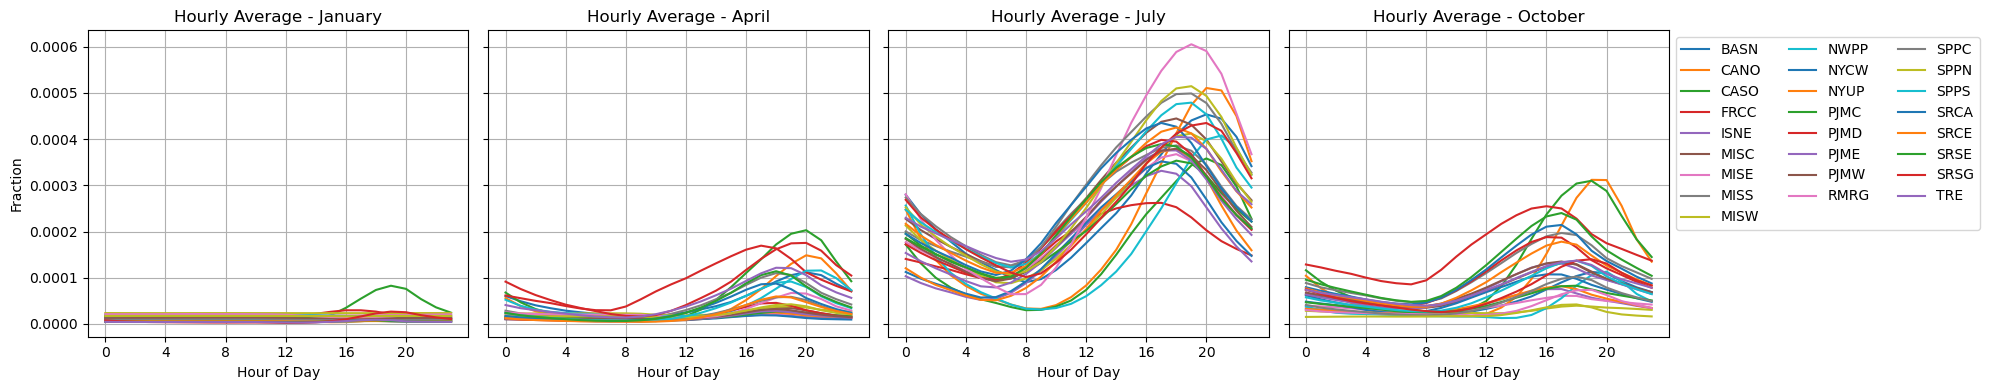

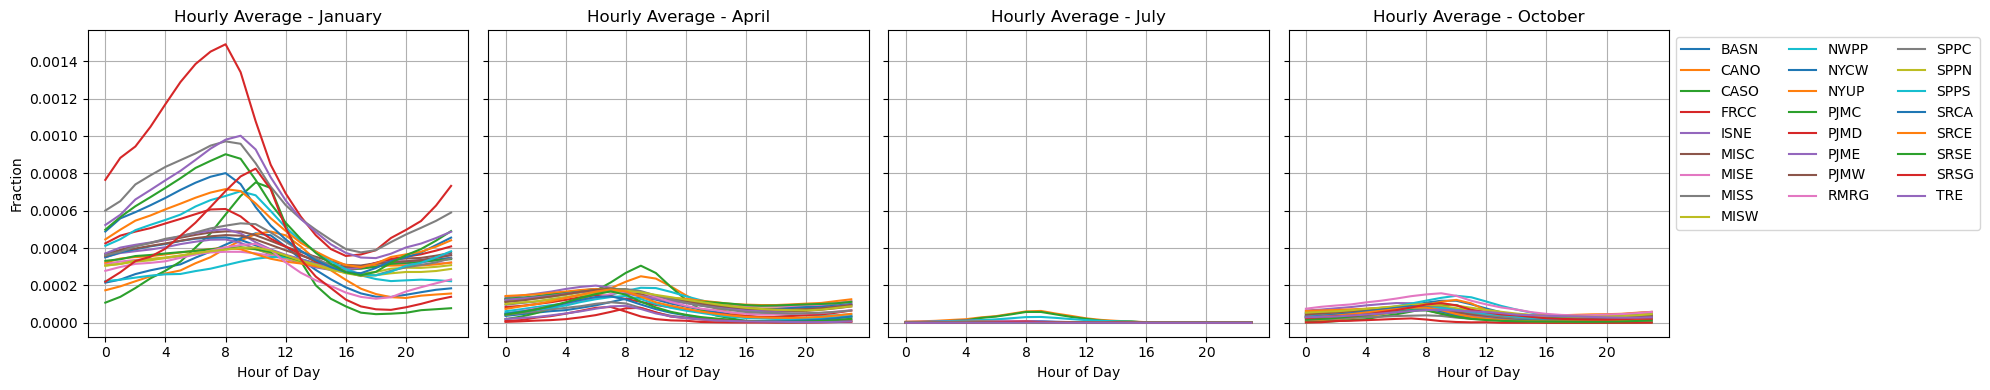

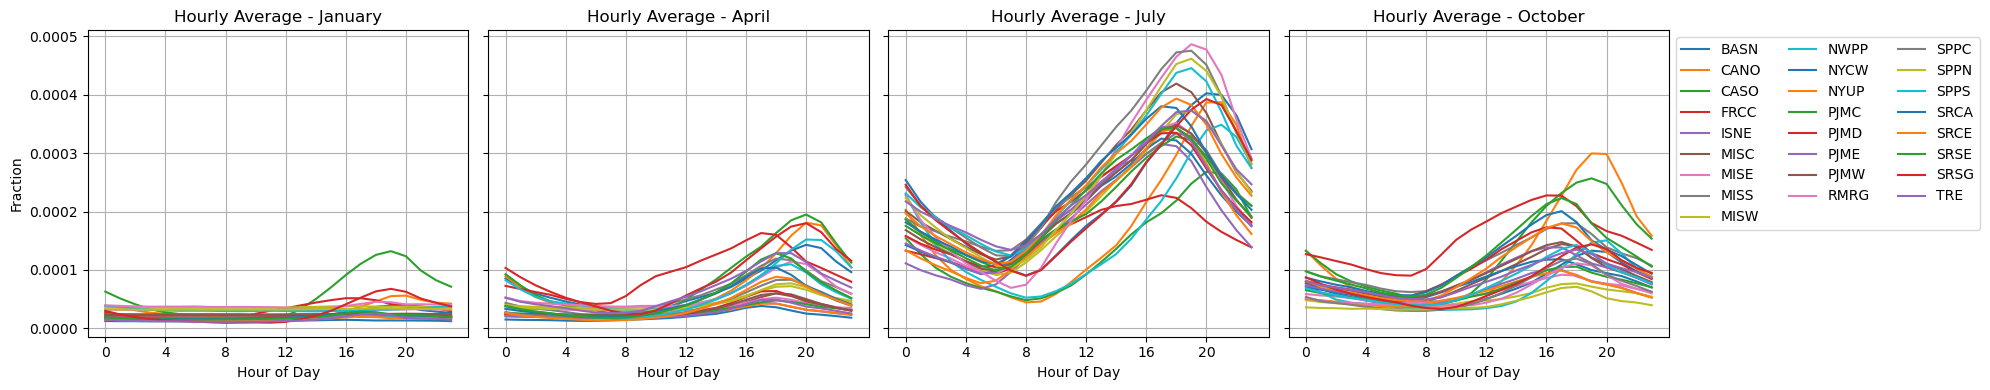

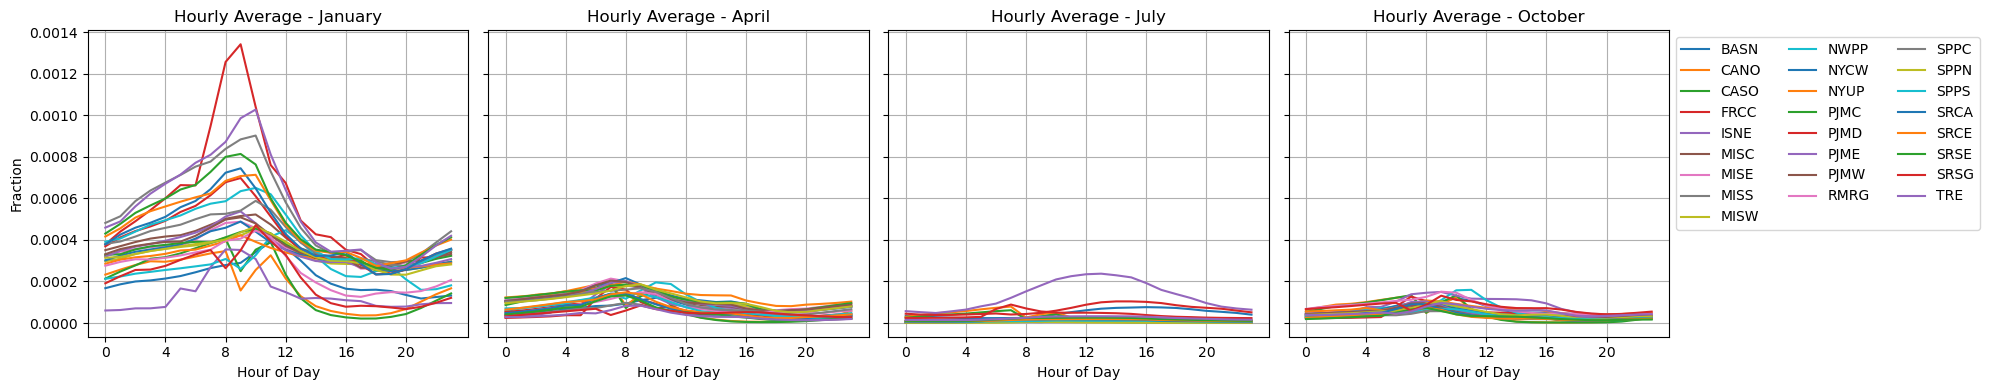

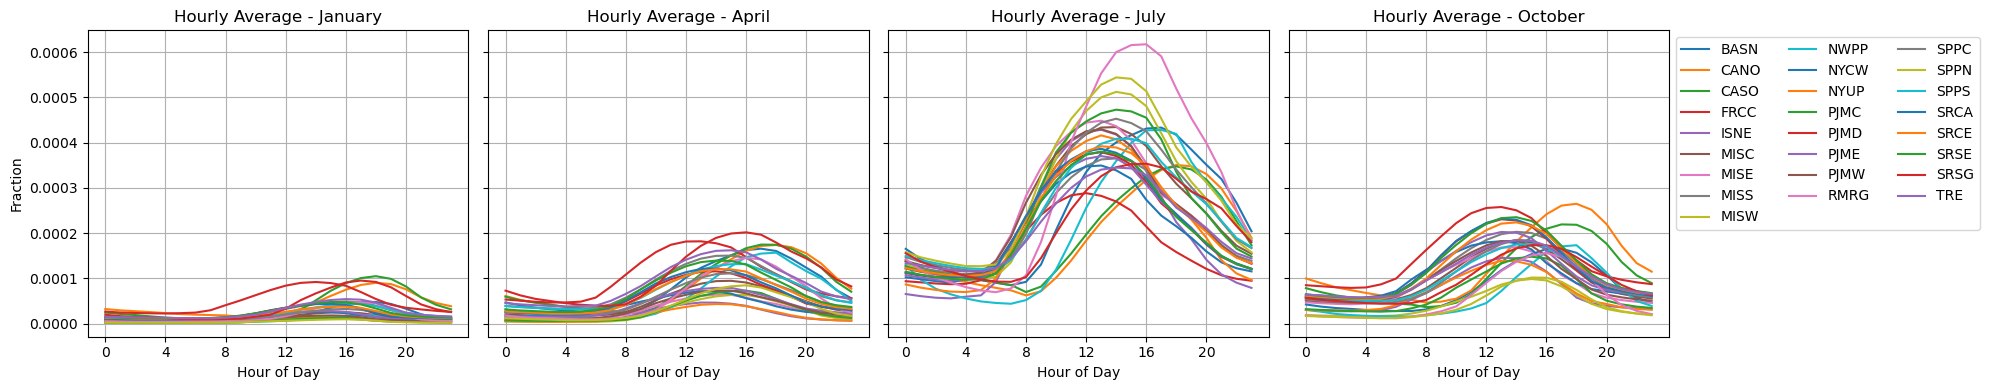

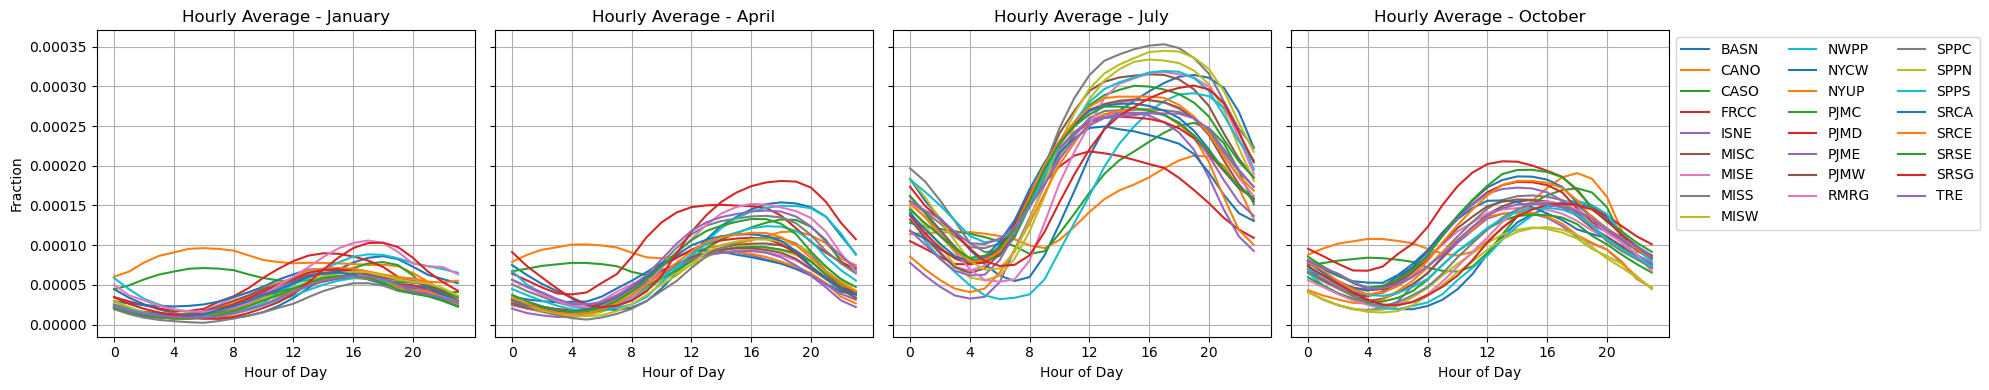

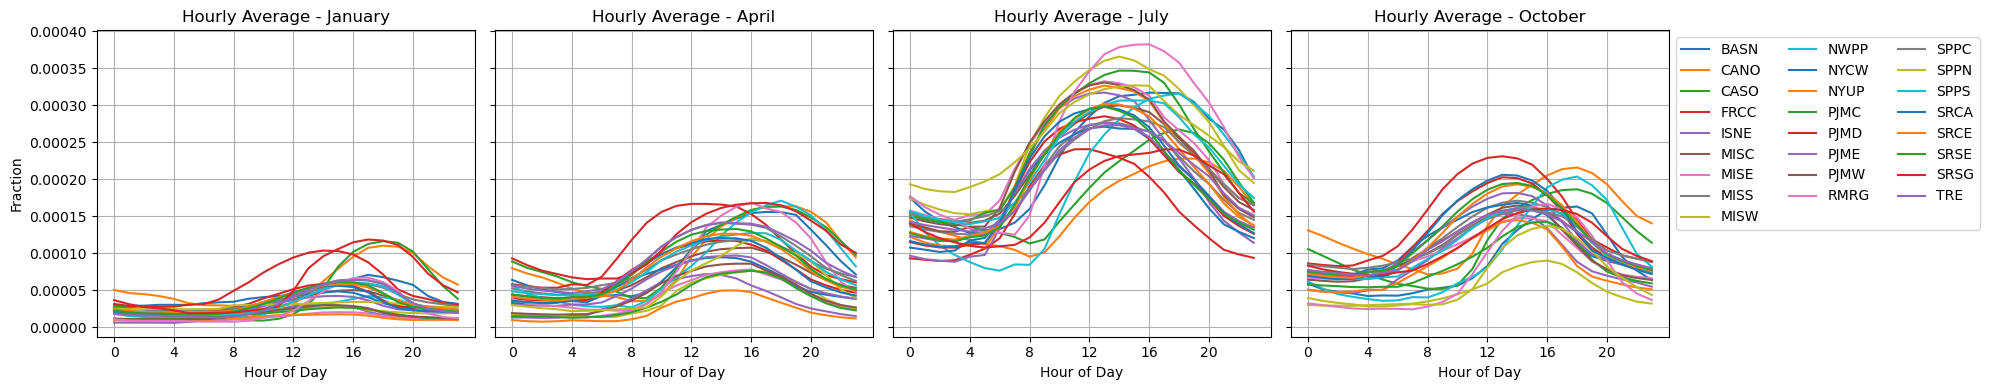

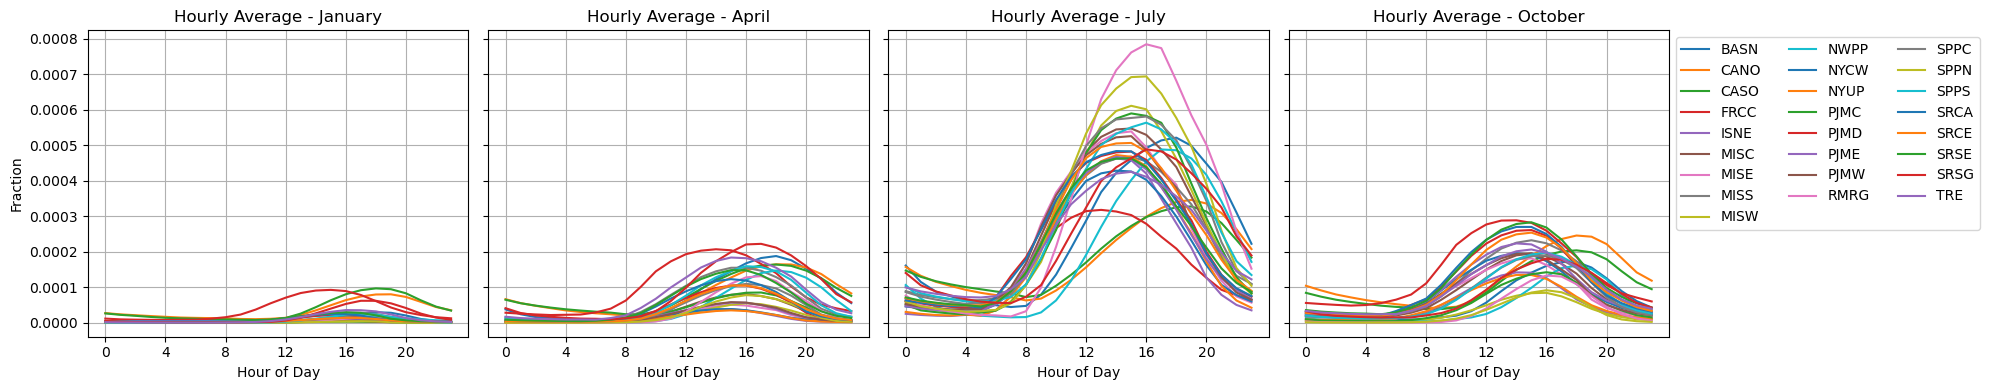

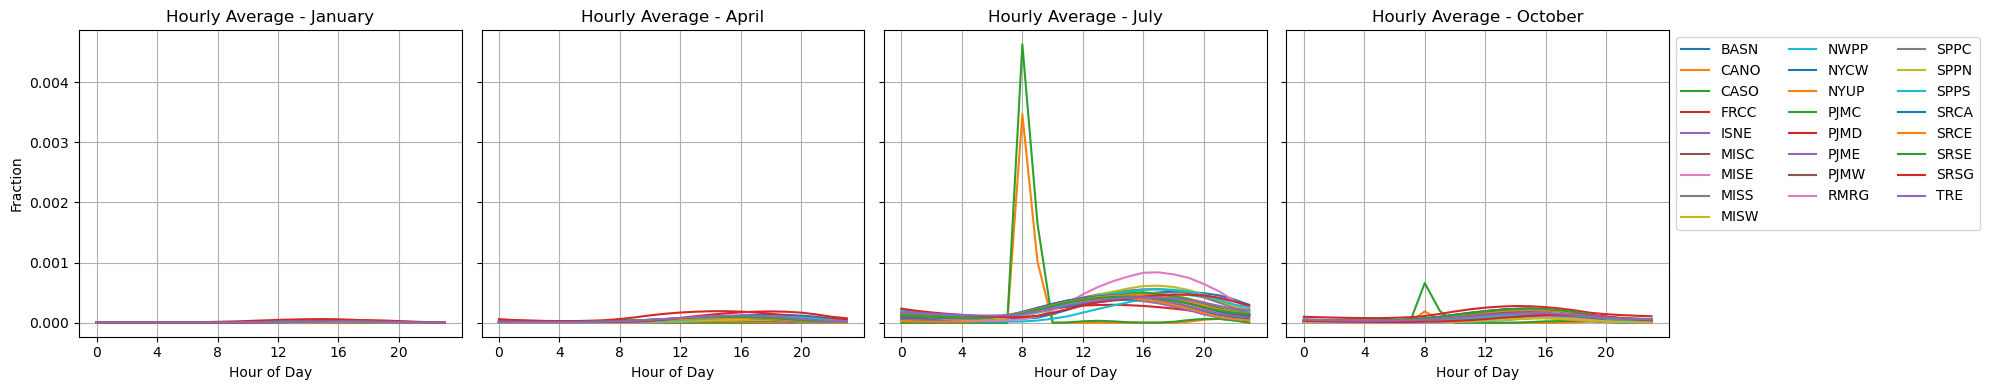

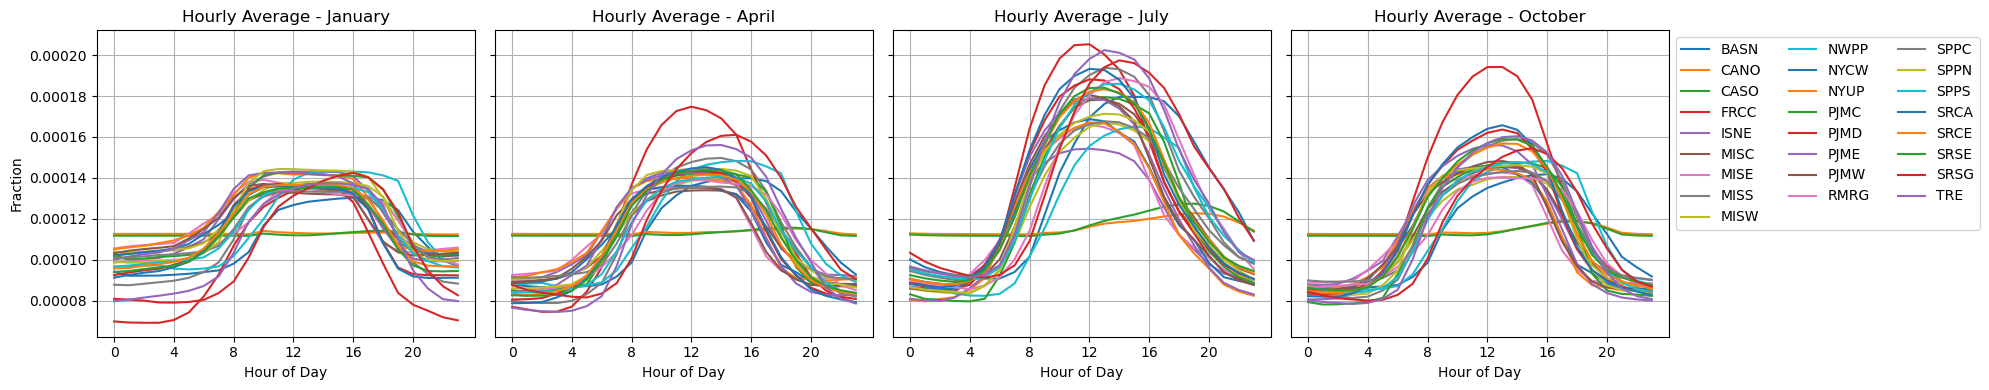

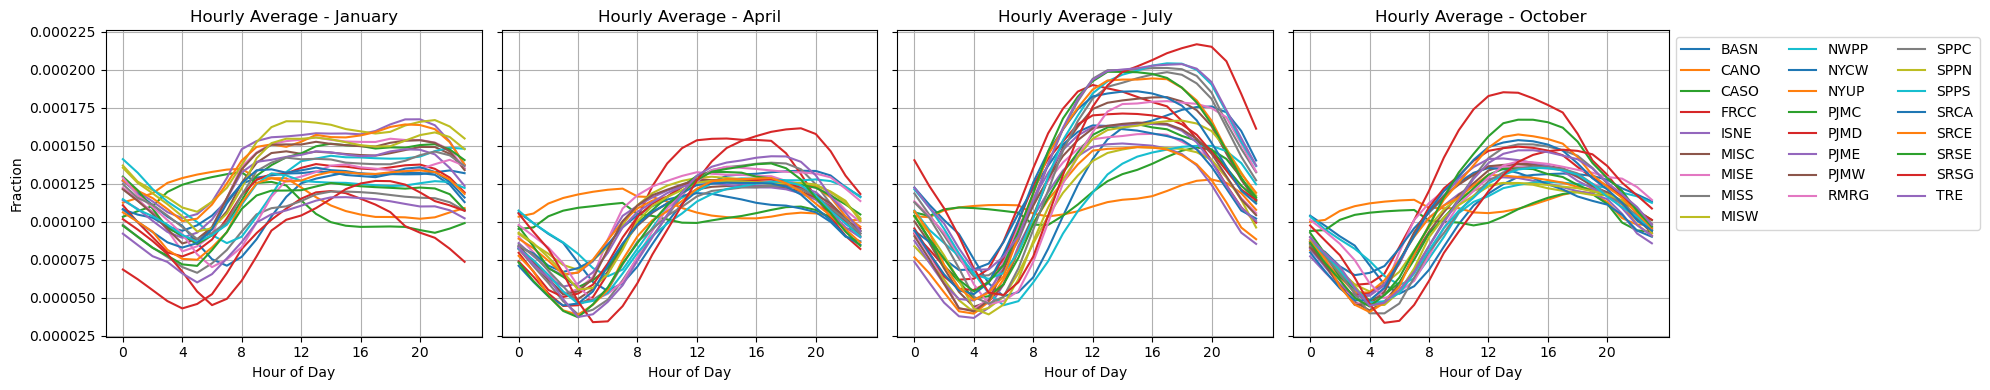

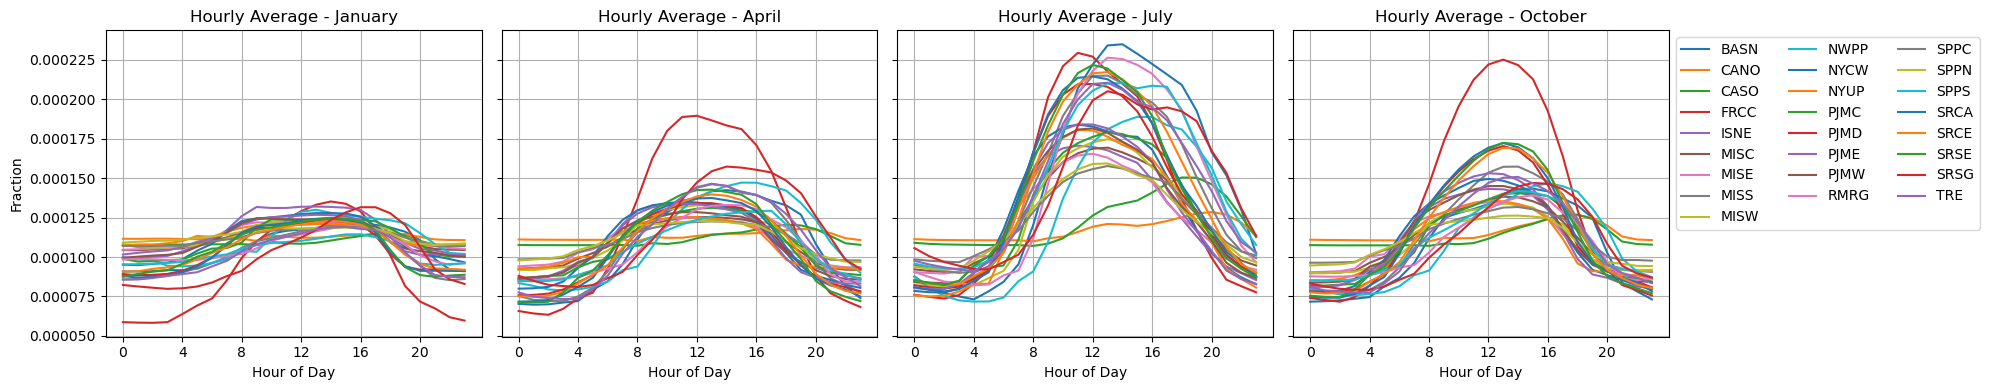

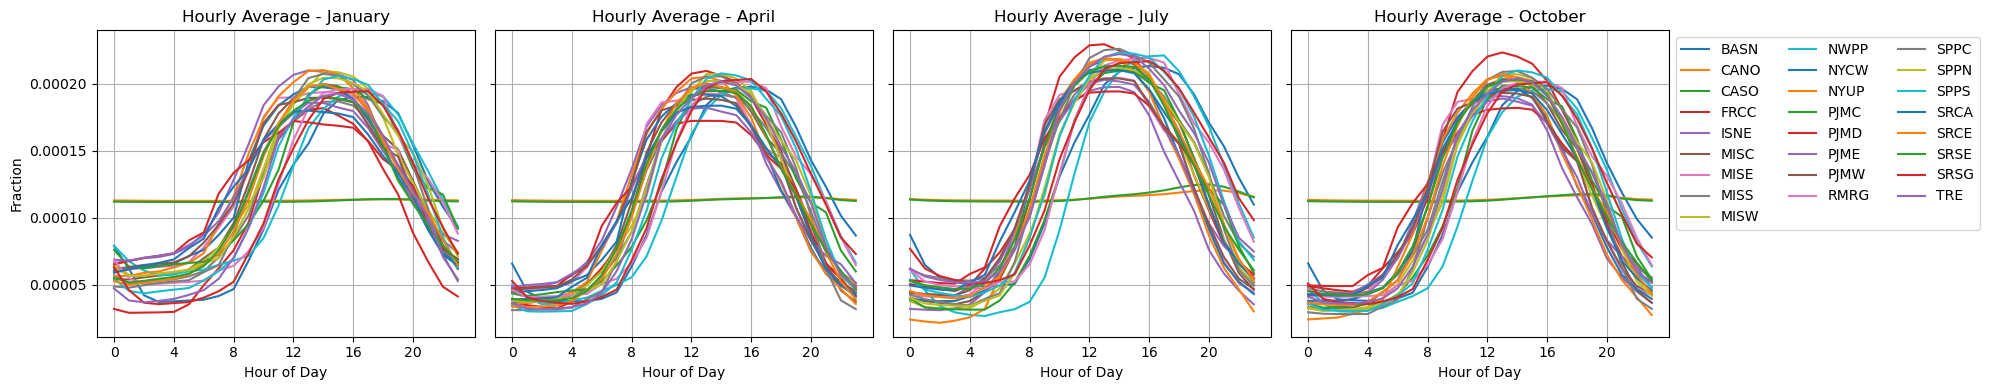

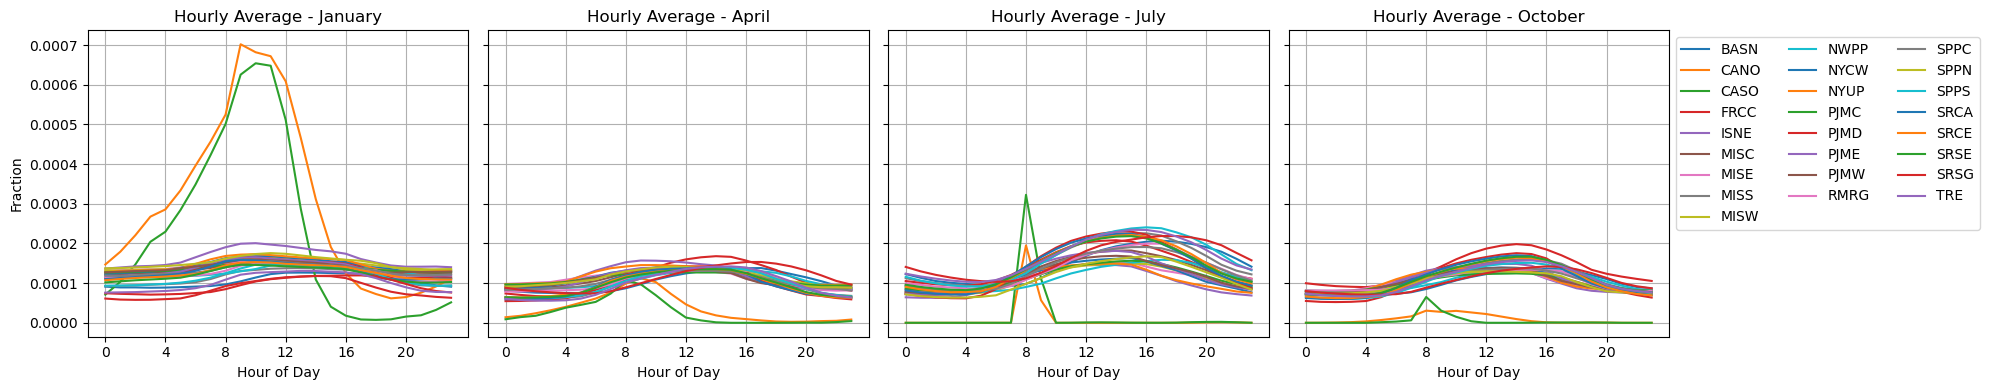

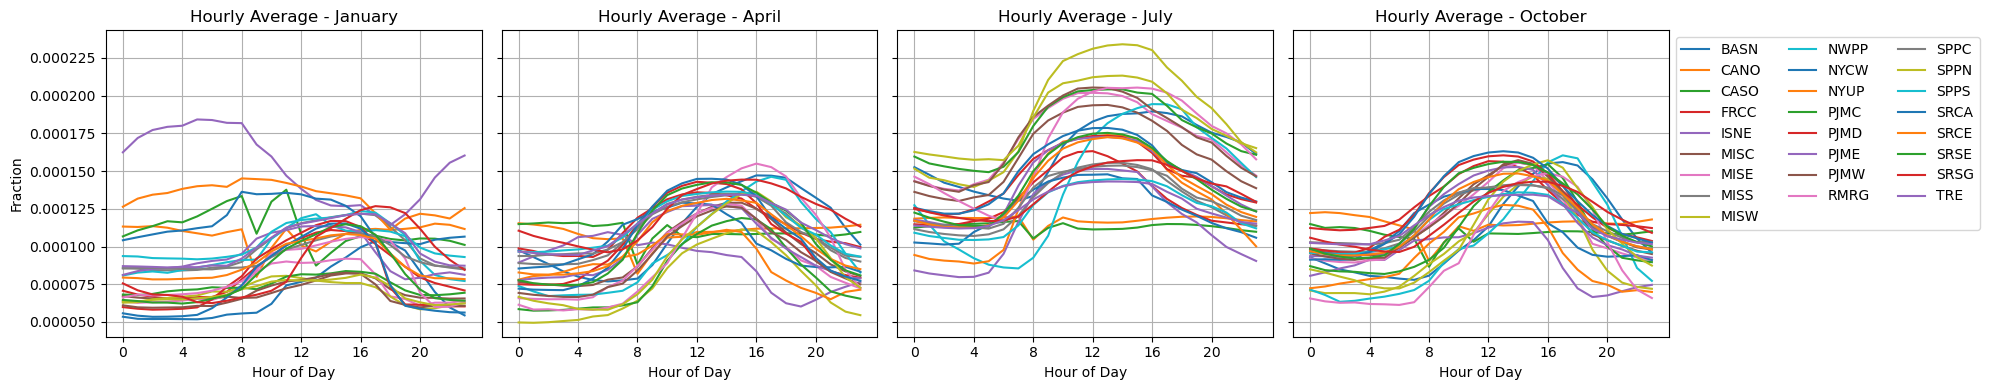

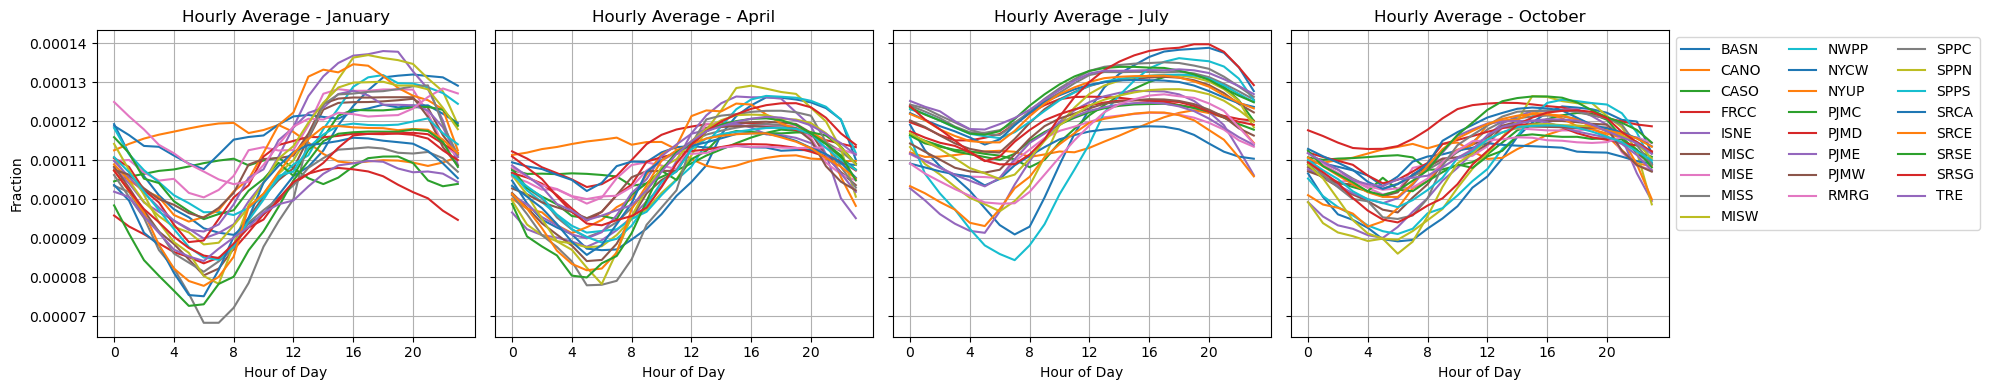

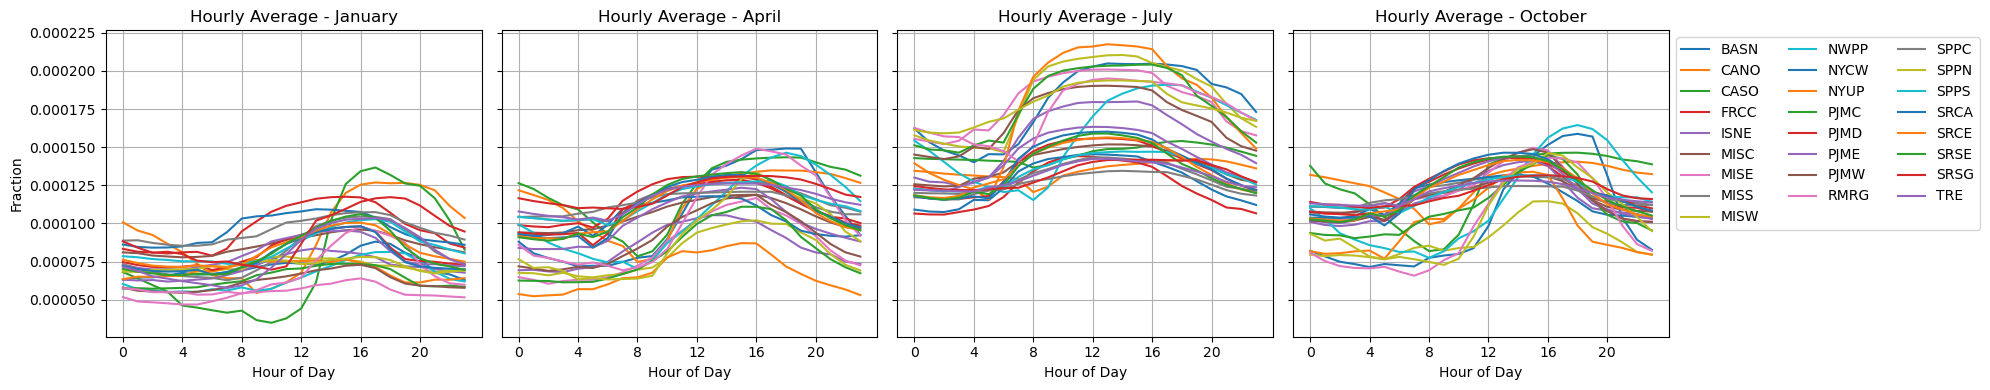

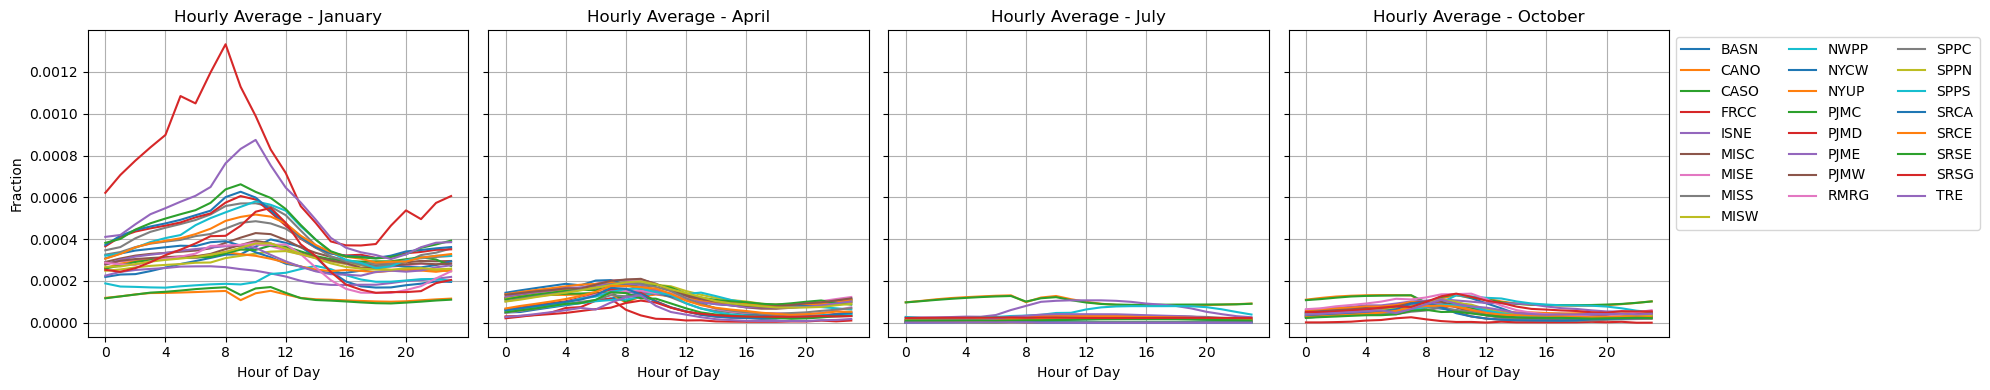

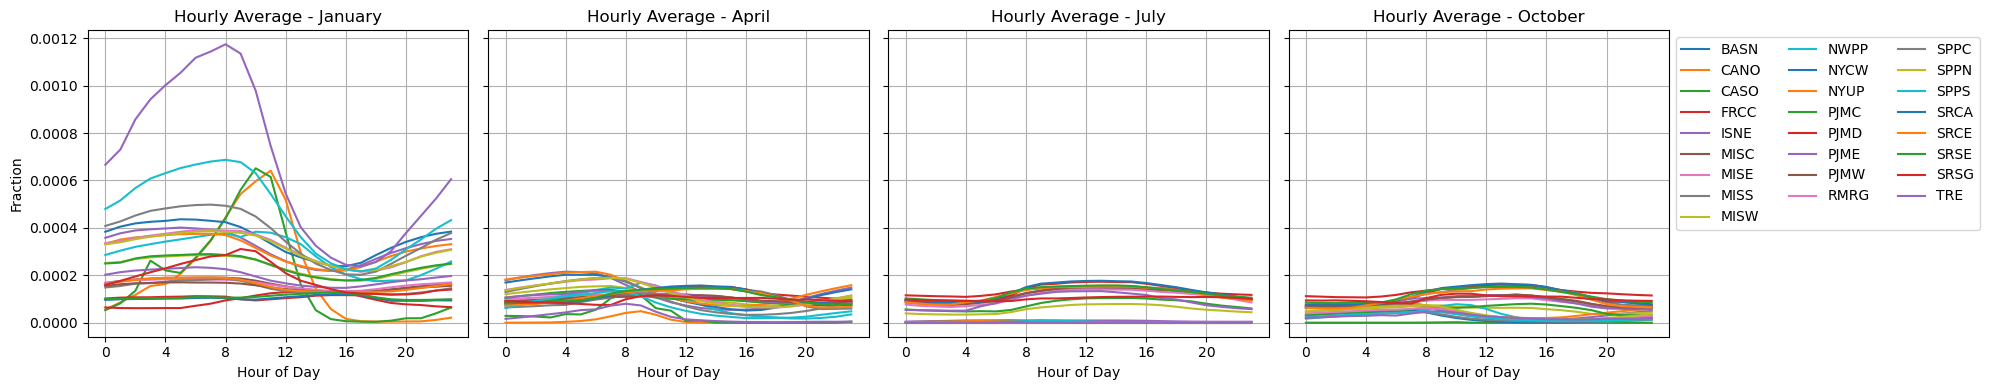

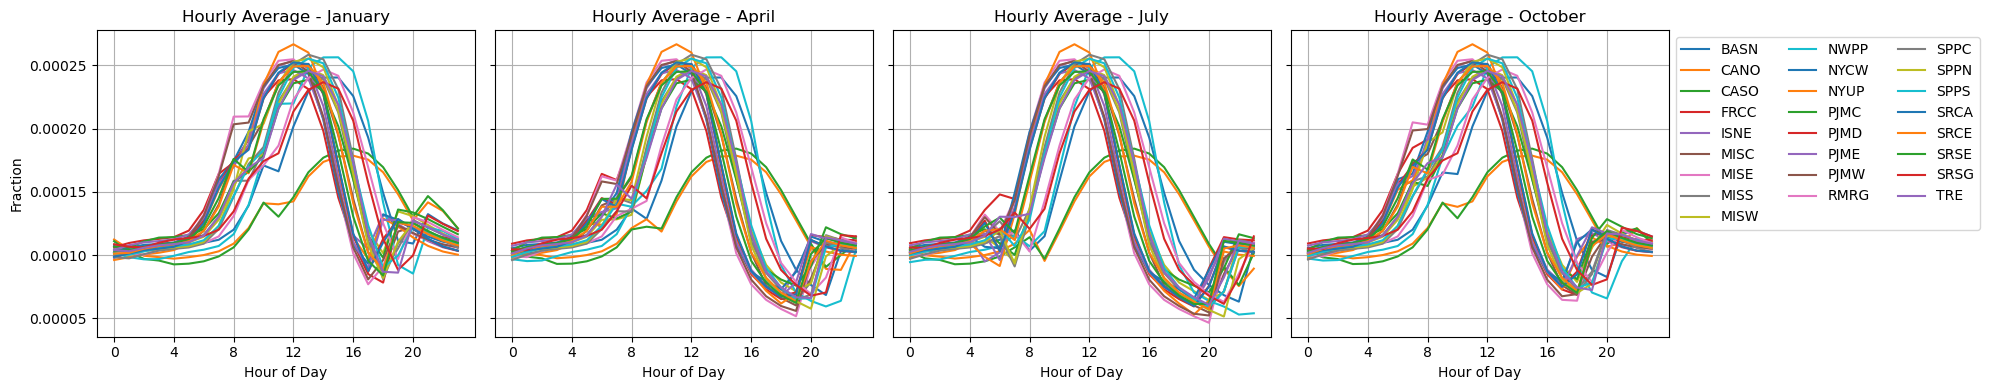

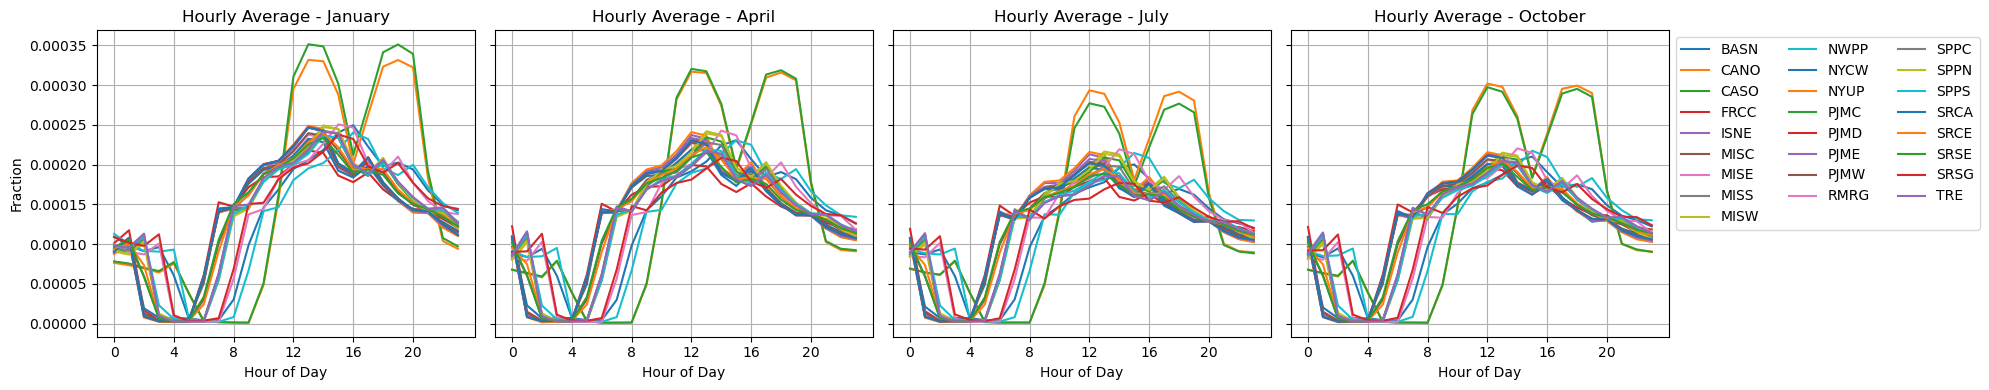

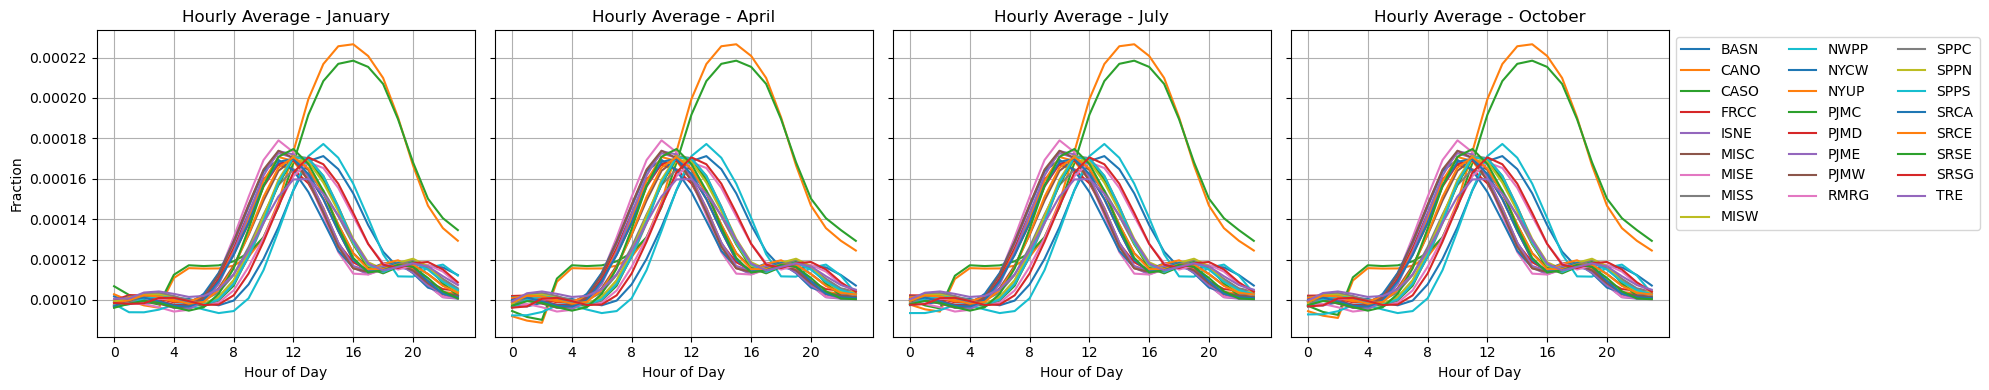

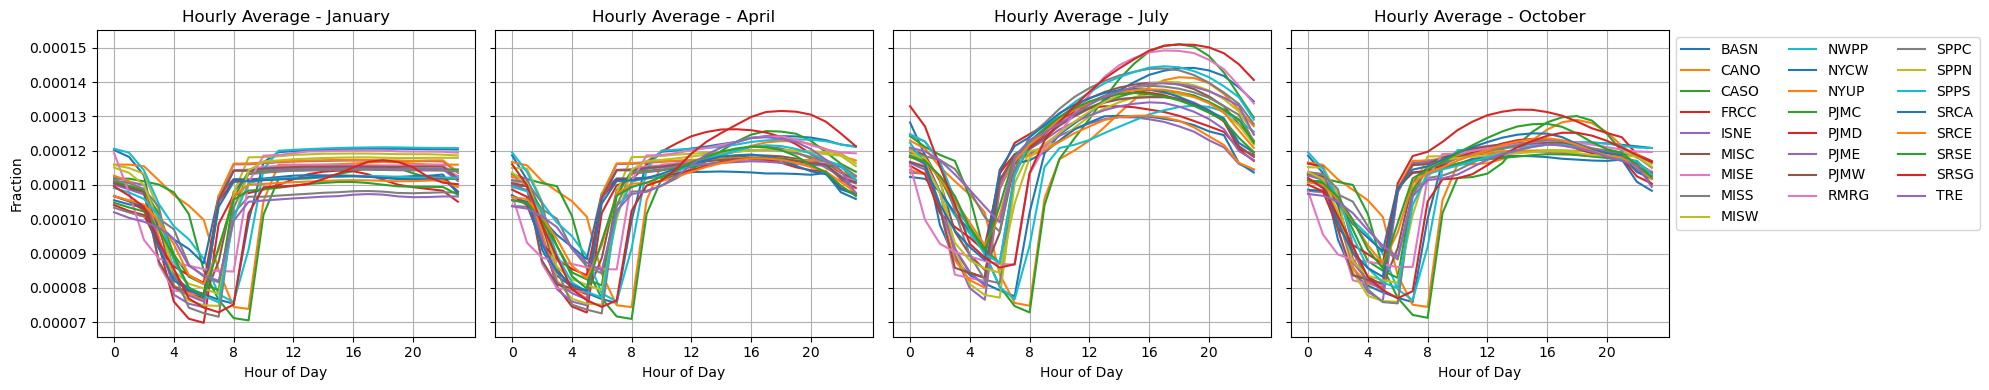

In [39]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the JSON file
# file_path = 'sample_dat/tsv_load_usstate_2024_comm_short.json'

# Starting indices for the selected months
month_starts = {
    'January': 0,
    'April': 31 + 28 + 31,  # Starting from the first day of April
    'July': 31 + 28 + 31 + 30 + 31,  # Starting from the first day of July
    'October': 31 + 28 + 31 + 30 + 31 + 30 + 31 + 31 + 30  # Starting from the first day of October
}

# Function to calculate indices for each month
def get_month_indices(month_start, days_in_month):
    start_day = month_start * 24
    end_day = start_day + days_in_month * 24
    return np.arange(start_day, end_day)

# Weekday filter function (assuming the first day is Sunday)
def filter_weekdays(indices):
    return [i for i in indices if (i // 24) % 7 < 5]  # Weekdays are Mon-Fri

# Function to calculate hourly average for each day in the selected period
def calculate_hourly_average(values, indices):
    hourly_data = np.array(values)[indices]
    hourly_avg = np.mean(hourly_data.reshape(-1, 24), axis=0)
    return hourly_avg
    
def draw_plot(file_path, sec, bld, eu):
    with open(file_path, 'r') as file:
        data = json.load(file)
    filtered_data = data[sec][eu][bld]['load shape']

    # Define the months to be extracted (January, April, July, October)
    month_days = {
        'January': 31,
        'April': 30,
        'July': 31,
        'October': 31
    }
    
    # Create subplots for each month with hourly averages and x-axis intervals of 4 hours
    fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey=True)
    
    # Plot hourly averages for each selected month
    for idx, (month_name, month_start) in enumerate(month_starts.items()):
        days_in_month = month_days[month_name]
        month_indices = get_month_indices(month_start, days_in_month)
        weekday_indices = filter_weekdays(month_indices)

        for state, values in filtered_data.items():
            # if state == 'CA' or state == 'MA' or state == 'FL' or state == 'WA' or state == 'DC' or state == 'TX':
            hourly_avg = calculate_hourly_average(values, weekday_indices)
            axs[idx].plot(hourly_avg, label=f'{state}')
        
        axs[idx].set_title(f'Hourly Average - {month_name}')
        axs[idx].set_xlabel('Hour of Day')
        axs[idx].set_xticks(np.arange(0, 24, 4))  # Set x-axis ticks every 4 hours
        axs[idx].grid(True)
        if idx == 0:
            axs[idx].set_ylabel('Fraction')
        if idx == 3:
            axs[idx].legend(loc='upper left', bbox_to_anchor=(1, 1), ncols=3)
    
    plt.tight_layout()
    plt.savefig(f'diagnostics/seasonal_fraction/State_{sec}_{bld}_{eu}.png',dpi=100, bbox_inches='tight')



def compare_plot(file_paths, sec, bld, eu):
    labels=['New', 'Old']
    assert len(file_paths) == 2 and len(labels) == 2, "Exactly two datasets must be provided."

    month_days = {
        'January': 31,
        'April': 30,
        'July': 31,
        'October': 31
    }

    fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey=True)

    for idx, (month_name, month_start) in enumerate(month_starts.items()):
        days_in_month = month_days[month_name]
        month_indices = get_month_indices(month_start, days_in_month)
        weekday_indices = filter_weekdays(month_indices)

        for file_idx, file_path in enumerate(file_paths):
            with open(file_path, 'r') as file:
                data = json.load(file)
            # print(f"{file_path} {sec} {list(data[sec][eu].keys())}")
            filtered_data = data[sec][eu][bld]['load shape']
            hourly_matrix = []

            for state, values in filtered_data.items():
                hourly_avg = calculate_hourly_average(values, weekday_indices)
                hourly_matrix.append(hourly_avg)

            hourly_matrix = np.array(hourly_matrix)
            mean_values = np.mean(hourly_matrix, axis=0)
            std_dev = np.std(hourly_matrix, axis=0)
            upper_band = mean_values + std_dev
            lower_band = mean_values - std_dev

            # Plot: use different colors for each file
            color = f'C{file_idx}'  # matplotlib default color cycle
            axs[idx].plot(mean_values, label=f'{labels[file_idx]} - Mean', color=color)
            axs[idx].fill_between(range(24), lower_band, upper_band, color=color, alpha=0.2, label=f'{labels[file_idx]} ±1 Std Dev')

        axs[idx].set_title(f'Hourly Average - {month_name}')
        axs[idx].set_xlabel('Hour of Day')
        axs[idx].set_xticks(np.arange(0, 24, 4))
        axs[idx].grid(True)
        if idx == 0:
            axs[idx].set_ylabel('Fraction')
        if idx == 3:
            axs[idx].legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.savefig(f'diagnostics/seasonal_fraction/Compare_EMM_{sec}_{bld}_{eu}.png', dpi=100, bbox_inches='tight')

# #########################################################################################

In [ ]:
file_path = 'json/alldecimals/tsv_load_state_2024.json'
# file_path = 'json/alldecimals/tsv_load_emm_2024.json'

draw_plot(file_path, 'residential', 'SF', 'heating')
draw_plot(file_path, 'residential', 'SF', 'cooling')
draw_plot(file_path, 'residential', 'MF', 'heating')
draw_plot(file_path, 'residential', 'MF', 'cooling')
# draw_plot(file_path, 'residential', 'MH', 'heating') #nodata
# draw_plot(file_path, 'residential', 'MH', 'cooling') #nodata
draw_plot(file_path, 'commercial', 'MediumOfficeDetailed', 'heating')
draw_plot(file_path, 'commercial', 'MediumOfficeDetailed', 'cooling')
draw_plot(file_path, 'commercial', 'LargeHotel', 'cooling')
draw_plot(file_path, 'commercial', 'LargeOfficeDetailed', 'cooling')
draw_plot(file_path, 'commercial', 'RetailStandalone', 'cooling')
draw_plot(file_path, 'commercial', 'Warehouse', 'cooling')

draw_plot(file_path, 'commercial', 'MediumOfficeDetailed', 'ventilation')
draw_plot(file_path, 'commercial', 'LargeHotel', 'ventilation')
draw_plot(file_path, 'commercial', 'LargeOfficeDetailed', 'ventilation')
draw_plot(file_path, 'commercial', 'RetailStandalone', 'ventilation')
draw_plot(file_path, 'commercial', 'Warehouse', 'ventilation')

draw_plot(file_path, 'commercial', 'MediumOfficeDetailed', 'pumps')
draw_plot(file_path, 'commercial', 'LargeHotel', 'pumps')
draw_plot(file_path, 'commercial', 'LargeOfficeDetailed', 'pumps')
draw_plot(file_path, 'commercial', 'RetailStandalone', 'pumps')
draw_plot(file_path, 'commercial', 'Warehouse', 'pumps')

draw_plot(file_path, 'commercial', 'MediumOfficeDetailed', 'lighting')
draw_plot(file_path, 'commercial', 'MediumOfficeDetailed', 'water heating')
draw_plot(file_path, 'commercial', 'MediumOfficeDetailed', 'plug loads')
draw_plot(file_path, 'commercial', 'LargeHotel', 'refrigeration')


In [ ]:
# file_paths = ['json/6decimals/tsv_load_EMM.json','json/v2024/tsv_load_EMM.json']
# compare_plot(file_paths, 'residential', 'SF', 'heating')
# compare_plot(file_paths, 'residential', 'SF', 'cooling')
# compare_plot(file_paths, 'residential', 'MF', 'heating')
# compare_plot(file_paths, 'residential', 'MF', 'cooling')
# compare_plot(file_paths, 'commercial', 'MediumOfficeDetailed', 'heating')
# compare_plot(file_paths, 'commercial', 'MediumOfficeDetailed', 'cooling')
# compare_plot(file_paths, 'commercial', 'LargeHotel', 'cooling')
# compare_plot(file_paths, 'commercial', 'LargeOfficeDetailed', 'cooling')
# compare_plot(file_paths, 'commercial', 'RetailStandalone', 'cooling')
# compare_plot(file_paths, 'commercial', 'Warehouse', 'cooling')

# compare_plot(file_paths, 'commercial', 'MediumOfficeDetailed', 'ventilation')
# compare_plot(file_paths, 'commercial', 'LargeHotel', 'ventilation')
# compare_plot(file_paths, 'commercial', 'LargeOfficeDetailed', 'ventilation')
# compare_plot(file_paths, 'commercial', 'RetailStandalone', 'ventilation')
# compare_plot(file_paths, 'commercial', 'Warehouse', 'ventilation')

# compare_plot(file_paths, 'commercial', 'MediumOfficeDetailed', 'pumps')
# compare_plot(file_paths, 'commercial', 'LargeHotel', 'pumps')
# compare_plot(file_paths, 'commercial', 'LargeOfficeDetailed', 'pumps')
# compare_plot(file_paths, 'commercial', 'RetailStandalone', 'pumps')
# compare_plot(file_paths, 'commercial', 'Warehouse', 'pumps')

# compare_plot(file_paths, 'commercial', 'MediumOfficeDetailed', 'lighting')
# compare_plot(file_paths, 'commercial', 'MediumOfficeDetailed', 'water heating')
# compare_plot(file_paths, 'commercial', 'MediumOfficeDetailed', 'plug loads')
# compare_plot(file_paths, 'commercial', 'LargeHotel', 'refrigeration')

#### find keys

In [ ]:
import json

# Load the data from the JSON file
file_path = 'tsv_load_usstate_2024.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Navigate to the "load shape" section
# load_shape_keys = data['commercial']['cooling']['MediumOfficeDetailed']['load shape'].keys()
load_shape_keys = data['residential']['cooling'].keys()
# List all keys under "load shape"
print("Keys under 'load shape':")
for key in load_shape_keys:
    print(key)


### list unique values from a CSV

In [ ]:
import pandas as pd

file_path = 'csv/residential_emm.csv' 
df = pd.read_csv(file_path)

column_name = 'building_type'
unique_values = df[column_name].unique()

print(f"\nUnique values in the column '{column_name}':")
print(unique_values)


In [ ]:
import pandas as pd

file_path = 'csv/0823/residential_state.csv' 
df = pd.read_csv(file_path)

column_name = 'building_type'

# values_to_remove = ['Multi-Family with 2 - 4 Units', 'Single-Family Attached']
# df_cleaned = df[~df[column_name].isin(values_to_remove)]

values_to_keep = ['Mobile Home', 'Multi-Family with 5+ Units','Single-Family Detached']
df_cleaned = df[df[column_name].isin(values_to_keep)]

df_cleaned.to_csv(file_path, index=False)

unique_values = df_cleaned[column_name].unique()

print(f"\nUnique values in the column '{column_name}':")
print(unique_values)

